# Kaggle Competition: Plant Seedlings Classification

This competition involves multi-class classification on 12 groups of plants.

In [141]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Metric
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns


In [142]:

# Constants
image_dimensions = [299, 299]
batch_size = 64
num_classes = 12

In [143]:
def define_generators():
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True,
        validation_split=0.2,
        preprocessing_function=preprocess_input
    )

    train_generator = train_datagen.flow_from_directory(
        directory='/kaggle/input/plant-seedlings-classification/train',
        target_size=image_dimensions,
        batch_size=batch_size,
        color_mode='rgb',
        class_mode="categorical",
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        directory='/kaggle/input/plant-seedlings-classification/train',
        target_size=image_dimensions,
        batch_size=batch_size,
        color_mode='rgb',
        class_mode="categorical",
        subset='validation'
    )

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    test_generator = test_datagen.flow_from_directory(
        directory='/kaggle/input/plant-seedlings-classification/',
        classes=['test'],
        target_size=image_dimensions,
        batch_size=1,
        color_mode='rgb',
        shuffle=False,
        class_mode=None  # No labels for test data
    )

    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = define_generators()

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Found 794 images belonging to 1 classes.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

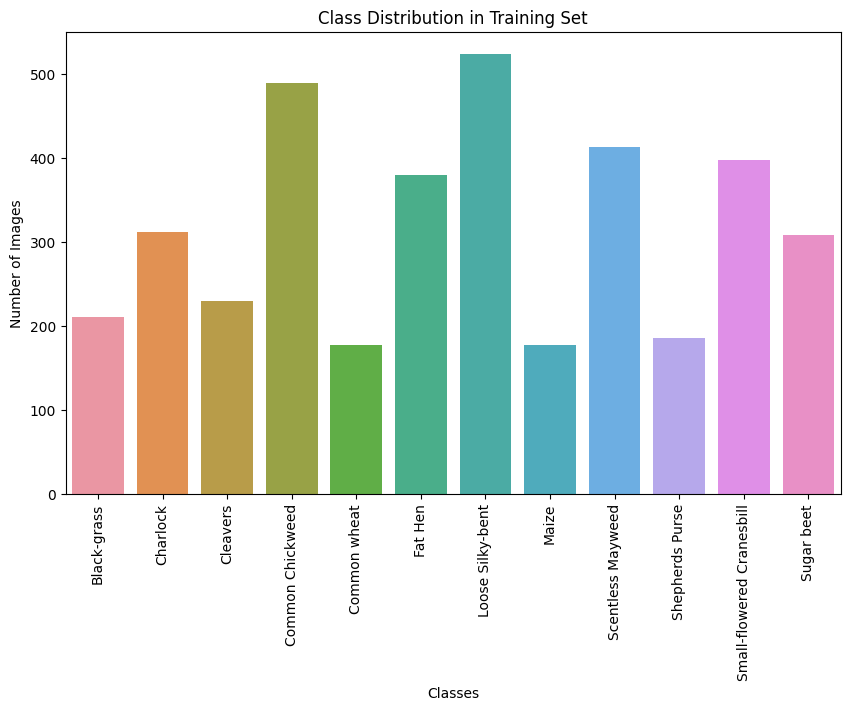

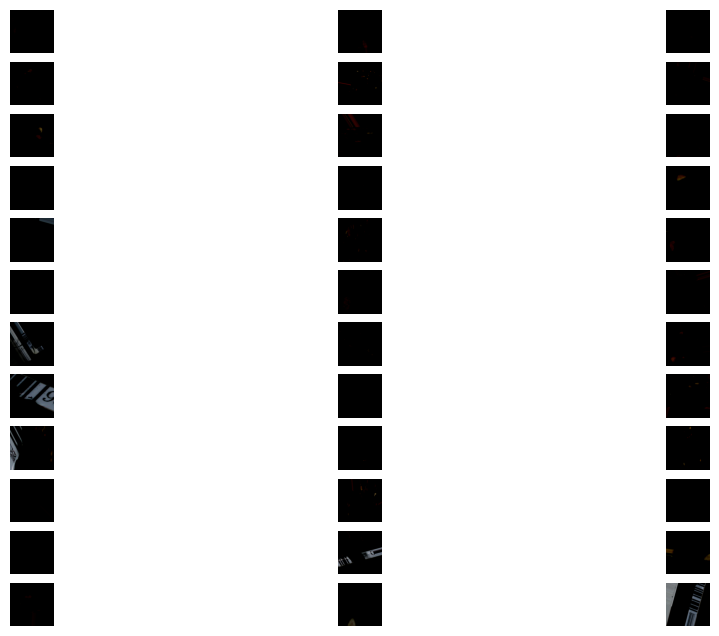

In [149]:
#Data Distribution
class_indices = train_generator.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for _, label_batch in train_generator:
    for label in label_batch:
        class_name = list(class_indices.keys())[np.argmax(label)]
        class_counts[class_name] += 1
    if sum(class_counts.values()) >= train_generator.samples:
        break

# Plotting class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.show()

#Sample Images
def plot_sample_images(image_generator, num_classes=12, num_samples=3):
    plt.figure(figsize=(12, 8))
    for i in range(num_classes):
        images, _ = next(image_generator)
        for j in range(num_samples):
            ax = plt.subplot(num_classes, num_samples, i * num_samples + j + 1)
            plt.imshow(images[j])
            plt.axis("off")
    plt.show()

plot_sample_images(train_generator)

In [145]:


def create_inceptionresnetv2():
    inputs = tf.keras.layers.Input([*image_dimensions, 3], name='image_input')
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation="softmax")(x)  # Specify num_classes
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

class MicroF1Score(Metric):
    def __init__(self, name='micro_f1_score', **kwargs):
        super(MicroF1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = K.cast(y_true, 'int32')
        y_pred = K.cast(K.round(y_pred), 'int32')
        true_positives = K.sum(K.cast(y_true * y_pred, 'float32'), axis=0)
        false_positives = K.sum(K.cast((1 - y_true) * y_pred, 'float32'), axis=0)
        false_negatives = K.sum(K.cast(y_true * (1 - y_pred), 'float32'), axis=0)
        self.true_positives.assign_add(K.sum(true_positives))
        self.false_positives.assign_add(K.sum(false_positives))
        self.false_negatives.assign_add(K.sum(false_negatives))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)  

In [146]:


model = create_inceptionresnetv2()

# Unfreeze some top layers
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# Compile and train the model
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=[MicroF1Score()])

model.fit(train_generator, 
          epochs=10, 
          steps_per_epoch=np.ceil(train_generator.samples / batch_size), 
          validation_data=validation_generator,
          validation_steps=np.ceil(validation_generator.samples / batch_size),
          callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
loss, micro_f1_score = model.evaluate(validation_generator, steps=np.ceil(validation_generator.samples / batch_size))
print(f"Validation Loss: {loss}, Micro F1 Score: {micro_f1_score}")


Epoch 1/10
60/60 [==============================] - 210s 2s/step - loss: 1.0353 - micro_f1_score: 0.6622 - val_loss: 6.3656 - val_micro_f1_score: 0.3040 - lr: 5.0000e-04
Epoch 2/10
60/60 [==============================] - 145s 2s/step - loss: 0.4345 - micro_f1_score: 0.8646 - val_loss: 1.4290 - val_micro_f1_score: 0.6734 - lr: 5.0000e-04
Epoch 3/10
60/60 [==============================] - 145s 2s/step - loss: 0.3878 - micro_f1_score: 0.8743 - val_loss: 4.0267 - val_micro_f1_score: 0.4627 - lr: 5.0000e-04
Epoch 4/10
60/60 [==============================] - 145s 2s/step - loss: 0.3052 - micro_f1_score: 0.9031 - val_loss: 0.6334 - val_micro_f1_score: 0.8258 - lr: 5.0000e-04
Epoch 5/10
60/60 [==============================] - 145s 2s/step - loss: 0.2557 - micro_f1_score: 0.9211 - val_loss: 0.5522 - val_micro_f1_score: 0.8336 - lr: 5.0000e-04
Epoch 6/10
60/60 [==============================] - 147s 2s/step - loss: 0.2724 - micro_f1_score: 0.9152 - val_loss: 0.8703 - val_micro_f1_score: 0.79

In [147]:
import pandas as pd

# Make predictions
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

# Get the filenames from the generator
filenames = test_generator.filenames

# Get the class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Map class indices to class labels
labels = (train_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
predicted_classes = [labels[k] for k in predicted_class_indices]

# Create a DataFrame with filenames and predicted classes
results = pd.DataFrame({"file": filenames, "species": predicted_classes})

# Save the results to a CSV file
results.to_csv("submission.csv", index=False)


794/794 [==============================] - 22s 23ms/step


# Conclusion:

In this project I was able to experiment with transfer learning for the first time. Not shown in this notebook is the experimentation with a different prebuilt model: InceptionV3, but after discovering that Inception-ResNetv2 typically offered better performance at the cost of additional computational resources; I decided to use a Kaggle notebook where I can easily train using my GPU.

This project had a similar feel to the cancer detection project in terms of applying augmentations and generating images in batches.

I believe that there is a lot of room for improvement and exploration in terms of augmentation and model architecture.

Overall, I am happy to be able to explore the use of transfer learning.

In the future I plan to use this project or one similar to assist in The Bahamas' agricultural industry which is the second largest revenue driver of The Bahamas